In [41]:
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
import numpy as np

In [2]:
# read in US as graph
G = ox.graph_from_place('Massachusetts, USA', network_type='drive')

In [3]:
G = ox.io.load_graphml('data/MA_drive.osm')

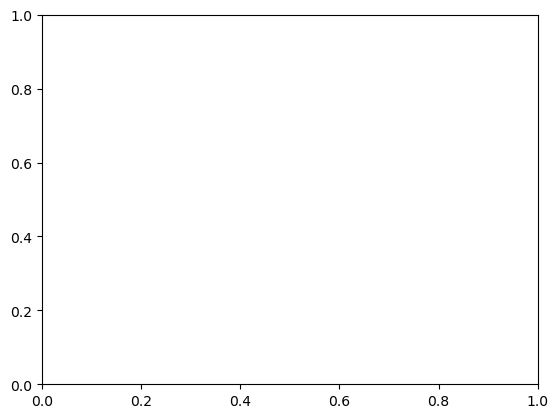

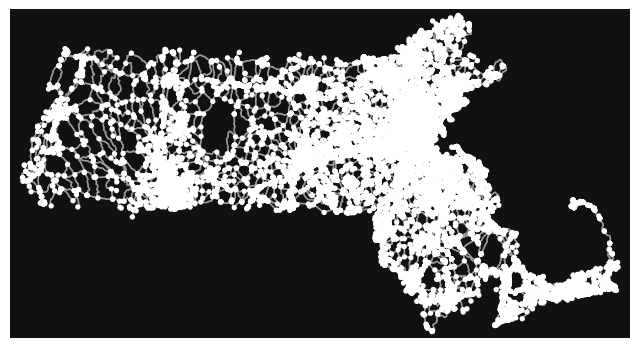

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [30]:
# fig, ax = plt.subplots()
ox.plot_graph(G_sub)
# ox.plot_graph(landfills,ax=ax)

In [5]:
ox.save_graphml(G,'data/MA_drive.osm')

In [19]:
cf = '["highway"~"motorway|motorway_link|trunk|trunk_link|primary|primary_link|secondary|secondary_link'\
        '|tertiary|tertiary_link"]'
G_sub = ox.graph_from_place('Massachusetts, USA', simplify=True, custom_filter=cf)
print(ox.graph_to_gdfs(G_sub, nodes=False)['highway'].value_counts())
print('-'*40)
print(ox.graph_to_gdfs(G, nodes=False)['highway'].value_counts())

highway
secondary                          26798
tertiary                           18969
primary                             9939
motorway_link                       4454
motorway                            2175
trunk                               2046
secondary_link                      1034
trunk_link                           885
primary_link                         699
tertiary_link                        372
[secondary, tertiary]                 72
[secondary, motorway_link]            14
[trunk, motorway]                     14
[motorway, motorway_link]              9
[secondary, primary]                   8
[secondary, trunk_link]                8
[motorway_link, primary]               5
[motorway_link, tertiary]              5
[tertiary_link, tertiary]              4
[primary_link, primary]                4
[trunk, trunk_link]                    3
[trunk_link, primary]                  2
[trunk_link, tertiary]                 2
[tertiary, trunk_link]                 2
[primary

In [67]:
# use OSM tags to find landfills as points of interest, print number found
place_name = "Massachusetts, USA"
landfills_wNA = ox.geometries.geometries_from_place(place_name, tags={"landuse": "landfill"})
landfills = landfills_wNA.dropna(subset=['name']) # drop NA

print(f"Found {len(landfills)} landfills in {place_name}")

# print names of landfills found in place
for i,landfill in landfills.iterrows():
    print(f"{landfill['name']} \tat {landfill['addr:housenumber']} {landfill['addr:street']} \tin {landfill['addr:city']}, {landfill['addr:state']} {landfill['addr:postcode']}")

Found 32 landfills in Massachusetts, USA
Nantucket Town Landfill 	at nan nan 	in nan, nan nan
Orleans Transfer Station 	at nan nan 	in nan, nan nan
Orleans Transfer Station 	at nan nan 	in nan, nan nan
Town Landfill 	at nan nan 	in nan, nan nan
Cohasset Heights Landfill 	at nan nan 	in nan, nan nan
Norwell Town Dump 	at nan nan 	in nan, nan nan
Crow Lane Landfill 	at nan nan 	in nan, nan nan
Newbury Landfill 	at nan nan 	in nan, nan nan
Shpack Landfill 	at nan nan 	in nan, nan nan
Rumford Avenue Landfill and Composting Facility 	at nan nan 	in nan, nan nan
Landfill Wheelabrator Saugus Inc. Ash Landfill 	at nan nan 	in nan, nan nan
Waltham Street Landfill (capped) 	at nan nan 	in nan, nan nan
Shaffer Landfill (closed) 	at nan nan 	in nan, nan nan
Charles George Landfill Superfund Site 	at nan nan 	in nan, nan nan
Titcomb Pit (Capped) 	at nan nan 	in nan, nan nan
Waste Management (Capped) 	at nan nan 	in nan, nan nan
old junkyard 	at nan nan 	in nan, nan nan
Woburn Sanitary Landfill 	at 

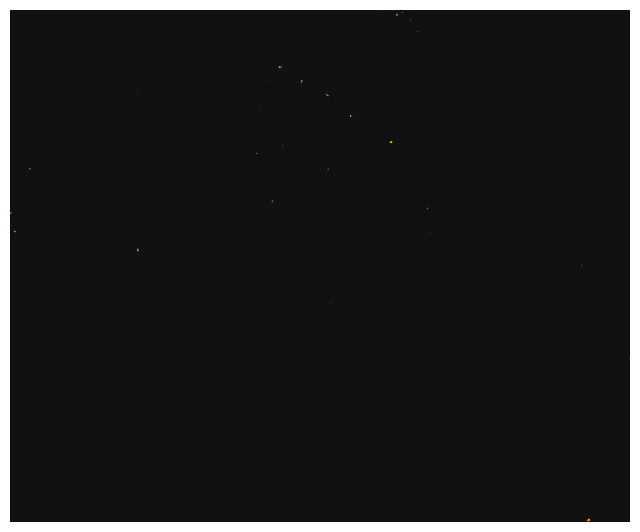

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [69]:
gpd.geopandas
ox.plot_footprints(landfills,edge_linewidth=100)

In [75]:
lf2 = landfills.copy()
lf2['geometry'] = [i.centroid for i in landfills.geometry.values]
landfills.geometry
len(dict(G.degree()).values()),\
len(G.nodes)

(262060, 262060)

From chat GPT:

In [ ]:
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch_geometric.nn as gnn
import torch_geometric.data as gdata
# read in US as graph
# G = ox.graph_from_place(‘Massachusetts, USA’, network_type=‘drive’)
# convert graph to PyTorch geometric data object
# data = ox.io.graph_to_pyg(G)
data = from_networkx(G)

# define GNN model
class LandfillGNN(gnn.MessagePassing):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__(aggr=‘add’)
        self.conv1 = gnn.GCNConv(in_channels, hidden_channels)
        self.conv2 = gnn.GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x
    
# create labeled dataset of existing landfill sites and non-landfill sites
landfills = ox.geometries.geometries_from_place(‘Massachusetts, USA’, tags={“landuse”: “landfill”})
non_landfills = ox.geometries.geometries_from_place(‘Massachusetts, USA’, tags={“landuse”: “residential”})
landfills[‘label’] = 1
non_landfills[‘label’] = 0
dataset = gdata.Data(
    x=torch.cat([torch.ones(len(landfills), 1), torch.zeros(len(non_landfills), 1)]),
    y=torch.cat([torch.ones(len(landfills)), torch.zeros(len(non_landfills))]),
    edge_index=data.edge_index,
    pos=data.pos,
)
# create and train GNN model
model = LandfillGNN(in_channels=dataset.x.size(1), hidden_channels=16, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(dataset.x, dataset.edge_index)
    loss = criterion(out, dataset.y.view(-1, 1))
    loss.backward()
    optimizer.step()
# use trained GNN model to predict the likelihood of a location being a good place for a landfill site
scores = model(dataset.x, dataset.edge_index).squeeze()
predictions = torch.sigmoid(scores)
landfill_probabilities = predictions[:len(landfills)]
non_landfill_probabilities = predictions[len(landfills):]
plt.hist(landfill_probabilities.detach().numpy(), bins=20, alpha=0.5, label=‘Landfill’)
plt.hist(non_landfill_probabilities.detach().numpy(), bins=20, alpha=0.5, label=‘Non-landfill’)
plt.xlabel(‘Probability’)
plt.ylabel(‘Count’)
plt.legend()
plt.show()

# Trying counties

In [19]:
import urllib.request as ul
from bs4 import BeautifulSoup as soup

url = 'https://www.epa.gov/lmop/project-and-landfill-data-state' 
req = ul.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
client = ul.urlopen(req)
htmldata = client.read()
client.close()

pagesoup_ph = soup(htmldata, "html.parser")
pd.read_html(htmldata)[0]


# Can cycle through multiple website layers using:

# upper_url = 'http://www.steelnumber.com/en/number_en10027_eu.php'
# upper_req = ul.Request(upper_url, headers={'User-Agent': 'Mozilla/5.0'})
# upper_client = ul.urlopen(upper_req)
# upper_htmldata = upper_client.read()
# upper_client.close()

# upper_pagesoup = soup(upper_htmldata, "html.parser")

# s_alloys = pd.DataFrame()

# ##############
landfills = pd.DataFrame()
for upper_link in pagesoup_ph.find_all('a'):
#     print(upper_link.get('href'), upper_link)
    if '.xlsx' in upper_link.get('href'):
        excel_url = 'https://www.epa.gov'+upper_link.get('href')
        out = pd.read_excel(excel_url, sheet_name='LMOP Database')
        landfills = pd.concat([landfills, out])

In [126]:
# landfills.to_csv('landfills.csv')
landfills = pd.read_csv('landfills.csv')

In [213]:
ejscreen1 = pd.read_csv('ejscreen2022.csv')

In [228]:
states = np.intersect1d(landfills['State'].values,ejscreen1['ST_ABBREV'].values)
lf = landfills.loc[[i in states for i in landfills['State']]]
# ej1 = ejscreen1.loc[[i in states for i in ejscreen1['ST_ABBREV']]]
ej1 = ejscreen1.copy()

features = [
    "OBJECTID", # unique ID for block group in geodatabase
    "ID", # census FIPS code for block group
    "ST_ABBREV", # name of state
    "CNTY_NAME", # country name
    "REGION", # US EPA region number
    "ACSTOTPOP", # total population
    "ACSTOTHH", # households (for limited English speaking)
    "MINORPOP", # people of color
    "LOWINCOME", #  low income
    "UNEMPLOYED", #  unemployed
    "LESSHS", #  less than high school education
    "PM25", # particulate matter 2.5
    "OZONE", # ozone
    "DSLPM", # diesel particulate matter
    "CANCER", # air toxics cancer risk
    "RESP", # air toxics respiratory HI
    "PTRAF", # traffic proximity
    "PNPL", # superfund proximity
    "PRMP", # RMP facility proximity
    "PTSDF", # hazardous waste proximity
    "UST", # underground storage tanks
    "PWDIS", # wastewater discharge
    "AREALAND", # land area in square meters
    "AREAWATER", # water area in square meters
    "NPL_CNT", # num superfund facilities in block group
    "TSDF_CNT", # num hazardous waste facilities in block group
    ]

feature_rename_dict = {
    "OBJECTID": 'unique ID for block group in geodatabase',
    "ID": 'census FIPS code for block group', 
    "STATE_NAME": 'name of state', 
    "CNTY_NAME": 'country name', 
    "REGION": 'US EPA region number', 
    "ACSTOTPOP": 'total population', 
    "ACSTOTHH": 'households (for limited English speaking)', 
    "MINORPCT": '% people of color', 
    "LOWINCPCT": '% low income', 
    "UNEMPPCT": '% unemployed', 
    "LESSHSPCT": '% less than high school education', 
    "PM25": 'particulate matter 2.5', 
    "OZONE": 'ozone', 
    "DSLPM": 'diesel particulate matter', 
    "CANCER": 'air toxics cancer risk', 
    "RESP": 'air toxics respiratory HI', 
    "PTRAF": 'traffic proximity', 
    "PNPL": 'superfund proximity', 
    "PRMP": 'RMP facility proximity', 
    "PTSDF": 'hazardous waste proximity', 
    "UST": 'underground storage tanks', 
    "PWDIS": 'wastewater discharge', 
    "AREA": 'land area in square meters', 
    "AREAWATER": 'water area in square meters', 
    "NPL_CNT": 'num superfund facilities in block group', 
    "TSDF_CNT": 'num hazardous waste facilities in block group', 
}

lf.loc[:,'County+Landfill+Op'] = ['-'.join([str(i),str(j),str(k)]) for i,j,k in zip(lf['County'].values, 
                                                                        lf['Landfill Name'].values,
                                                                        lf['Current Project Status'])]
lf['County'] = [str(i).replace(' city',' City').replace('Penuelas','Peñuelas')\
                .replace('Mayaguez','Mayagüez').replace('St. Thomas','St. Thomas Island')\
                .replace('Juana Diaz','Juana Díaz').replace('')
                for i in lf['County'].values]
lf = lf.loc[~lf['County+Landfill+Op'].duplicated(keep='last')]
lf['Operational'] = 0
lf['Shutdown'] = 0
lf['Potential'] = 0
lf.loc[(lf['Current Project Status']=='Operational') |
       (lf['Current Project Status']=='Construction'),'Operational']=1
lf.loc[(lf['Current Project Status']=='Shutdown'),'Shutdown']=1

lf.loc[(lf['Current Project Status']!='Operational')&(lf['Current Project Status']!='Construction')&
       (lf['Current Project Status']!='Shutdown'),'Potential']=1
lf = lf[['State','County','Latitude','Longitude','Waste in Place (tons)','Operational','Shutdown','Potential']]

In [229]:
lf_sc = lf[['Operational','Shutdown','Potential','State','County']].groupby(['State','County']).sum()
lf_sc[lf_sc>1]=1
[i for i in lf['County'].unique() if i not in ej1['CNTY_NAME'].unique()]

['nan', 'Dona Ana', 'Anasco']

In [230]:
ej1['CNTY_NAME'].unique()[['Ana' in i for i in ej1['CNTY_NAME'].unique()]]

array(['Doña Ana'], dtype=object)

In [224]:
lf['County'].unique()[['St.' in i for i in lf['County'].unique()]]

array(['St. Clair', 'St. Johns', 'St. Lucie', 'St. Joseph', 'St. Mary',
       'St. James', 'St. Landry', 'St. Tammany', "St. Mary's",
       'St. Louis', 'St. Francois', 'St. Croix', 'St. Thomas'],
      dtype=object)

In [138]:
ej1.groupby(['ST_ABBREV','CNTY_NAME']).sum()
lf
lf.loc[(lf['Current Project Status']=='Operational'),'Operational']=1
lf[['State','County','Operational']].groupby(['State']).sum()
# lf.columns
# lf.loc[(lf['State']=='AL')][['Landfill Name','Current Project Status']]

,County,Operational
State,,
AK,AnchorageJuneauKenai PeninsulaKodiak IslandAnc...,1.0
AL,PerryLimestoneMarshallTuscaloosaBlountPikeCalh...,4.0
AR,AshleyFultonFaulknerSebastianSebastianPhillips...,3.0
AZ,MaricopaApachePinalMaricopaMaricopaPinalPinalM...,1.0
CA,Contra CostaSacramentoSanta ClaraSanta ClaraIm...,49.0
CO,ArchuletaLa PlataBoulderMontrosePuebloWeldWeld...,4.0
CT,FairfieldHartfordWindhamHartfordHartfordTollan...,2.0
DE,New CastleNew CastleSussexNew CastleKent,3.0
FL,Miami-DadeSumterMadisonMarionMarionSarasotaPal...,18.0


In [68]:
ej1[features]

KeyError: "['STATE_ABBREV', 'MINORPOP', 'LOWINCOME', 'UNEMPLOYED', 'LESSHS'] not in index"